In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj
from aquarel import load_theme


In [4]:
################
## Households ##
################

@sj.simple
def euler(beta, r, sigma, C):
    Euler = (beta*(1+r(1)))**(-sigma)*C(1) - C
    
    return Euler

@sj.simple
def bc(r, A, y, C):
    budget_constraint = (1+r) * A(-1) + y - C - A
    
    return budget_constraint

################
## Government ##
################

@sj.simple
def govt(B, r, G, Y):
    T = (1+r)*B(-1) + G - B        # From government BC, solved for taxes
    y = Y - T                      # After-tax income
    
    Deficit = G - T                # Deficit. Bonds should make up the rest
    
    return T, y, Deficit

###################
## Interest Rate ##
###################

@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    
    return r

#####################
## Market Clearing ##
#####################

@sj.simple
def mkt_clearing_prod(A, Y, C, G, B, r, beta):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    
    return asset_mkt, goods_mkt

################
## Production ##
################

@sj.simple
def vpclear(phip, Pistar, ep, Pi, vp):
    vpres = ((1-phip) * Pistar**(-ep) * Pi**(ep)) + (Pi**(ep) * phip * vp(-1)) - vp
    
    return vpres

@sj.simple
def firm(ep, Pi, x1, x2, mc, C, sigma, phip, beta, Pistar, eta, chi, vp, Z):
    w = mc*Z
    L = (w*C**(-1)/chi)**(1/eta)
    Y = Z*L/vp
    x1res = (C**(-sigma) * mc * Y) + (phip * beta * Pi(1)**(ep) * x1(1)) - x1
    x2res = (C**(-sigma) * Y) + (phip * beta * Pi(1)**(ep-1) * x2(1)) - x2
    mcres = ep/(ep-1) * Pi * ((C**(-sigma) * mc * Y) + (phip * beta * Pi(1)**(ep) * x1(1)))/((C**(-sigma) * Y) + (phip * beta * Pi(1)**(ep-1) * x2(1))) - Pistar
    
    return mcres, x1res, x2res, L, Y, w
    
@sj.simple
def prices(phip, Pistar, ep, Pi):
    pres = (1-phip) * Pistar**(1-ep) + phip - Pi**(1-ep)
    
    return pres

##################
## Central Bank ##
##################

@sj.simple
def fed(Pi, ishock, rss, phipi, rho, i):
    ires = (1-rho)*rss + rho*i(-1) + (1-rho)*phipi*(Pi-1) + ishock - i
    r_ante = i - (Pi(1)-1)
    
    return ires, r_ante

ra_prod = sj.create_model([euler, bc, ex_post_rate, mkt_clearing_prod, govt, firm,
                           fed, vpclear, prices], name = "RA Prod")

print(ra_prod.inputs)
print(ra_prod.outputs)

['beta', 'sigma', 'C', 'A', 'G', 'B', 'ep', 'Pi', 'x1', 'x2', 'mc', 'phip', 'Pistar', 'eta', 'chi', 'vp', 'Z', 'ishock', 'rss', 'phipi', 'rho', 'i']
['Euler', 'budget_constraint', 'r', 'asset_mkt', 'goods_mkt', 'T', 'y', 'Deficit', 'mcres', 'x1res', 'x2res', 'L', 'Y', 'w', 'ires', 'r_ante', 'vpres', 'pres']


In [6]:
cal_prod = ({'r_ante': 0.02})
cal_prod = ({'G': 0.2, 'B': .5, 'sigma': 1., 'chi': 1., 'rss': cal_prod['r_ante'], 'eta': 1.,
             'phip': 0.75, 'ep': 11, 'phipi': 1.5, 'Pi': 1., 'ishock': 0., 'Z': 1., 'rho': 0.8})

ss_prod = ra_prod.solve_steady_state(cal_prod,
                                     {'beta': 0.995, 'A': .5, 'x1': 4.65, 'x2': 5.12 , 'vp': 1., 'Pistar': 1.,
                                      'mc': 0.909091, 'C': 0.836, 'i': 0.01},
                                     {'asset_mkt': 0., 'budget_constraint': 0., 'x1res':0., 'x2res':0.,
                                      'vpres': 0., 'Euler': 0., 'mcres': 0., 'pres': 0., 'ires': 0.})

In [13]:
T = 300
dg = 0.01 * 0.6 ** np.arange(T)

unknowns = ['A', 'x1', 'x2', 'vp', 'Pistar', 'mc', 'C', 'i', 'Pi']
targets = ['asset_mkt', 'budget_constraint', 'x1res', 'x2res', 'vpres', 'Euler', 'mcres', 'pres', 'ires']
irf_prod = ra_prod.solve_impulse_linear(ss_prod, unknowns, targets, {'G': dg})
    
print(irf_prod)


<ImpulseDict: ['G', 'A', 'x1', 'x2', 'vp', 'Pistar', 'mc', 'C', 'i', 'Pi', 'Euler', 'budget_constraint', 'r', 'asset_mkt', 'goods_mkt', 'T', 'y', 'Deficit', 'mcres', 'x1res', 'x2res', 'L', 'Y', 'w', 'ires', 'r_ante', 'vpres', 'pres']>


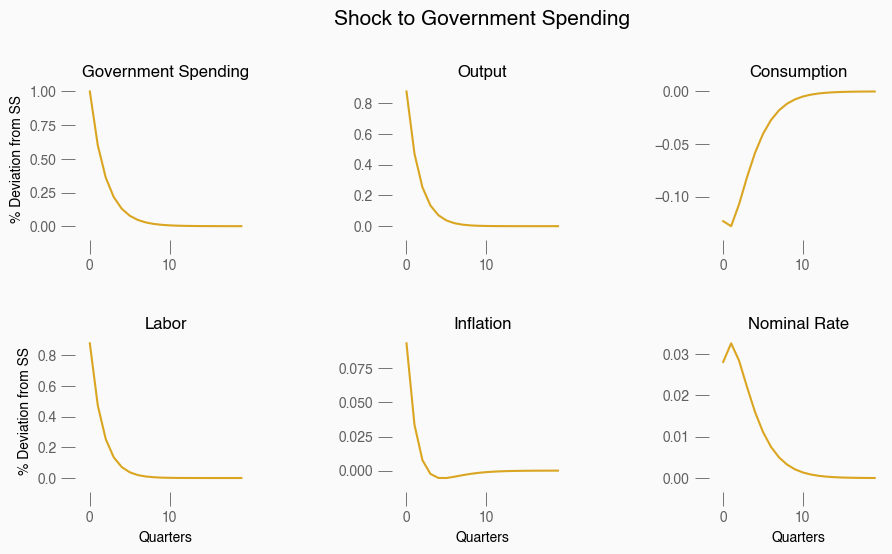

In [15]:
Thorizon = 20

theme = load_theme("minimal_light")
theme.apply()
ax0 = plt.figure(figsize=(10, 5)) 
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(2,3,1)
plt.plot(100*irf_prod['G'][:Thorizon], color='goldenrod')
plt.ylabel('% Deviation from SS')
plt.title('Government Spending')
ax1.set_facecolor('#FAFAFA')

ax2 = plt.subplot(2,3,2)
plt.plot(100*irf_prod['Y'][:Thorizon], color='goldenrod')
plt.title('Output')
ax2.set_facecolor('#FAFAFA')

ax3 = plt.subplot(2,3,3)
plt.plot(100*irf_prod['C'][:Thorizon], color='goldenrod')
plt.title('Consumption')
ax3.set_facecolor('#FAFAFA')

ax4 = plt.subplot(2,3,4)
plt.plot(100*irf_prod['L'][:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.ylabel('% Deviation from SS')
plt.title('Labor')
ax4.set_facecolor('#FAFAFA')

ax5 = plt.subplot(2,3,5)
plt.plot(100*irf_prod['Pi'][:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.title('Inflation')
ax5.set_facecolor('#FAFAFA')

ax6 = plt.subplot(2,3,6)
plt.plot(100*irf_prod['i'][:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.title('Nominal Rate')
ax6.set_facecolor('#FAFAFA')

plt.suptitle('Shock to Government Spending', y=1.05, fontsize=15)

theme.apply_transforms()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.9,
                    hspace=0.7)
plt.show()

In [17]:
da = 0.0065 * 0.9 ** np.arange(T)

irf_prod1 = ra_prod.solve_impulse_linear(ss_prod, unknowns, targets, {'Z': da})

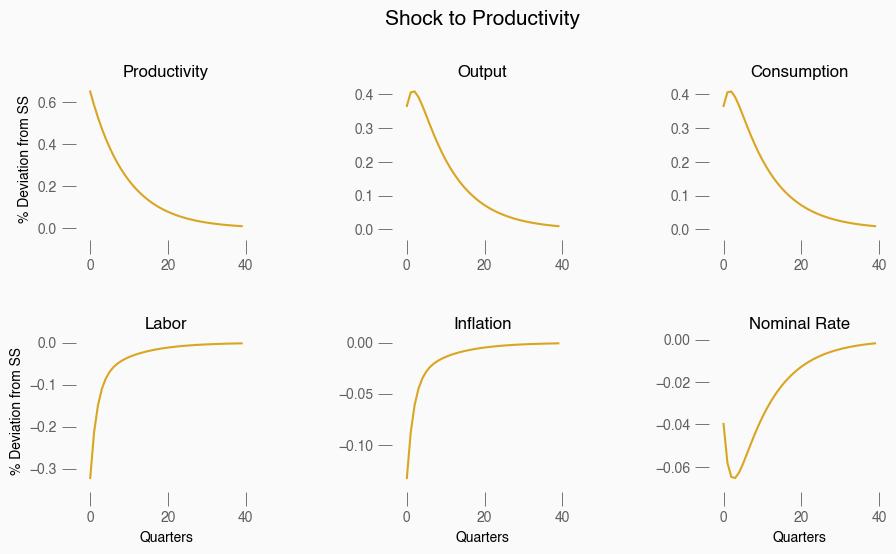

In [19]:
Thorizon = 40

theme = load_theme("minimal_light")
theme.apply()
ax0 = plt.figure(figsize=(10, 5)) 
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(2,3,1)
plt.plot(100*irf_prod1['Z'][:Thorizon], color='goldenrod')
plt.ylabel('% Deviation from SS')
plt.title('Productivity')
ax1.set_facecolor('#FAFAFA')

ax2 = plt.subplot(2,3,2)
plt.plot(100*irf_prod1['Y'][:Thorizon], color='goldenrod')
plt.title('Output')
ax2.set_facecolor('#FAFAFA')

ax3 = plt.subplot(2,3,3)
plt.plot(100*irf_prod1['C'][:Thorizon], color='goldenrod')
plt.title('Consumption')
ax3.set_facecolor('#FAFAFA')

ax4 = plt.subplot(2,3,4)
plt.plot(100*irf_prod1['L'][:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.ylabel('% Deviation from SS')
plt.title('Labor')
ax4.set_facecolor('#FAFAFA')

ax5 = plt.subplot(2,3,5)
plt.plot(100*irf_prod1['Pi'][:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.title('Inflation')
ax5.set_facecolor('#FAFAFA')

ax6 = plt.subplot(2,3,6)
plt.plot(100*irf_prod1['i'][:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.title('Nominal Rate')
ax6.set_facecolor('#FAFAFA')

plt.suptitle('Shock to Productivity', y=1.05, fontsize=15)

theme.apply_transforms()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.9,
                    hspace=0.7)
plt.show()